<a href="https://colab.research.google.com/github/MarcosRMG/Estudos-Data-Science/blob/main/FIPE_Honda_CG_125_ES_2014.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


<font size=6>**Preço da Moto HONDA/CG 125 FAN ES/2014 125 ES 2014**</font>


---



Autor: Marcos Galvão

[Linkedin](https://br.linkedin.com/in/marcosrmgalvao)

[Github](https://github.com/MarcosRMG)

[Blog Jogando com Dados](https://jogandocomdados.blogspot.com/)


---

# 1 Bibliotecas

## 1.1 Instalações

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.9MB/s 
     |████████████████████████████████| 9.5MB 41.4MB/s 
     |████████████████████████████████| 2.1MB 43.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


## 1.2 Importações

In [2]:
# Tratamento
import pandas as pd
from urllib.request import urlopen
import requests
# Visualização
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# Estatísticas
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Projeção
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

## 1.3 Configuraçẽos

In [45]:
# Consifurações de visualização gráfica
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = [16, 8]

# 2 Dados 

In [4]:
url = 'https://www.fipemotos.com/tabelafipe/motos/HONDA/CG-125-FAN-ES/2014-Gasolina'
header = {
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36'
}
'''
dados: informações coletadas no site da tabela FIPE
'''
r = requests.get(url)
dados = pd.read_html(r.text, header=0)[1]

## 2.1 Tratamento dos dados

In [5]:
dados

,Mês,Valor,Variação
0,Março 2021,"R$ 6.412,00","3,49 %"
1,Fevereiro 2021,"R$ 6.196,00","0,73 %"
2,Janeiro 2021,"R$ 6.151,00","3,50 %"
3,Dezembro 2020,"R$ 5.943,00","0,34 %"
4,Novembro 2020,"R$ 5.923,00","0,34 %"
...,...,...,...
67,Agosto 2015,"R$ 6.170,00","1,78 %"
68,Julho 2015,"R$ 6.062,00","1,07 %"
69,Junho 2015,"R$ 5.998,00","0,28 %"
70,Maio 2015,"R$ 5.981,00","-0,17 %"


In [6]:
'''
Tratamento das colunas de data e valor
'''
mes = []
ano = []
valor = []
for i in dados['Mês'].str.split():
  mes.append(i[0])

for i in dados['Mês'].str.split():
  ano.append(i[1])

for i in dados['Valor'].str.split():
  valor.append(i[1])

contador = 0
for i in valor:
  valor[contador] = valor[contador][:5].replace('.', '')
  contador += 1

In [7]:
# Atribuição das colunas
dados['mes'] = mes
dados['ano'] = ano
dados['valor'] = valor

In [8]:
# Dicionário para alteração do formato dos meses
meses = {
    'Fevereiro': '2', 
    'Janeiro': '1', 
    'Dezembro': '12', 
    'Novembro': '11', 
    'Outubro': '10',
    'Setembro': '11', 
    'Agosto': '8', 
    'Julho': '7', 
    'Junho': '6', 
    'Maio': '5', 
    'Abril': '4', 
    'Março': '3'
}

In [9]:
# Alteração dos valores da coluna mes
dados['mes'] = dados['mes'].map(meses) 

In [10]:
# Criação da coluna data
dados['data'] = dados['ano'] + '-' + dados['mes']

In [11]:
# Conversão da coluna data para datetime
dados['data'] = pd.to_datetime(dados['data'])

In [12]:
# Exclusão das colunas em formato antigo
dados.drop(['Mês', 'Variação', 'mes', 'ano', 'Valor'], inplace=True, axis=1)

In [13]:
# Renomeando a coluna
dados.rename({'Valor': 'valor'}, axis=1, inplace=True)

In [14]:
# Alteração do tipo de dados da coluna valor
dados['valor'] = dados['valor'].astype('int32')

In [15]:
# Definição do index do DataFrame
dados.set_index('data', inplace=True)
dados.head()

,valor
data,
2021-03-01,6412
2021-02-01,6196
2021-01-01,6151
2020-12-01,5943
2020-11-01,5923


# 3 Série Temporal

In [42]:
fig = px.line(dados, x=dados.index, y='valor', 
        title='Preço Moto Honda CG 125 ES 2014 (Tabela FIPE)')
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=dados.index, y=dados['valor'],
#                    mode='lines+markers'))
fig.update_layout(xaxis_title='Período',
                  yaxis_title='Valor')

## 3.1 Média móvel

In [17]:
# Média móvel de dois meses
dados['media_movel'] = dados['valor'].rolling(window=2).mean()

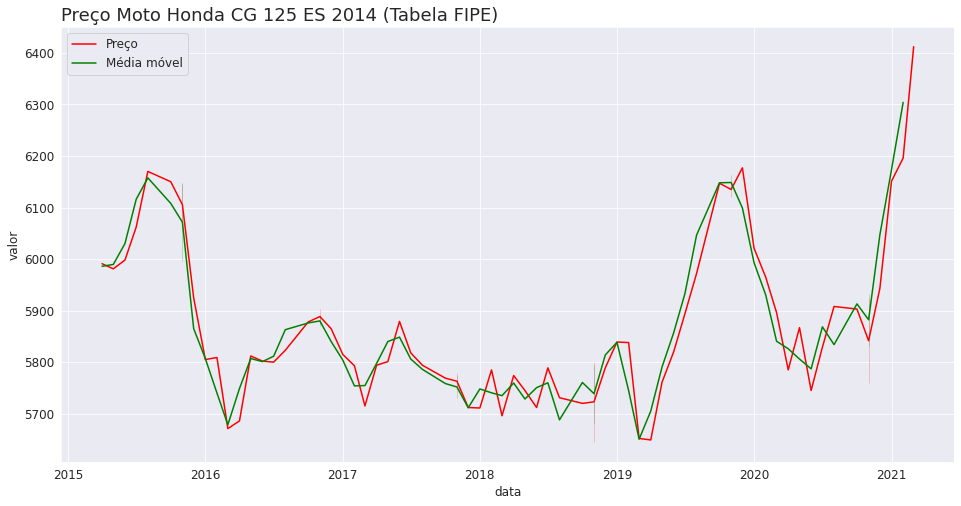

In [18]:
plt.figure(figsize=(16, 8))
sns.lineplot(x=dados.index, y='valor', data=dados, color='red', label='Preço')
sns.lineplot(x=dados.index, y='media_movel', data=dados, color='green', label='Média móvel')
plt.legend()
plt.title('Preço Moto Honda CG 125 ES 2014 (Tabela FIPE)', loc='left', 
          fontsize=18);

## 3.2 Decomposição e autocorrelação

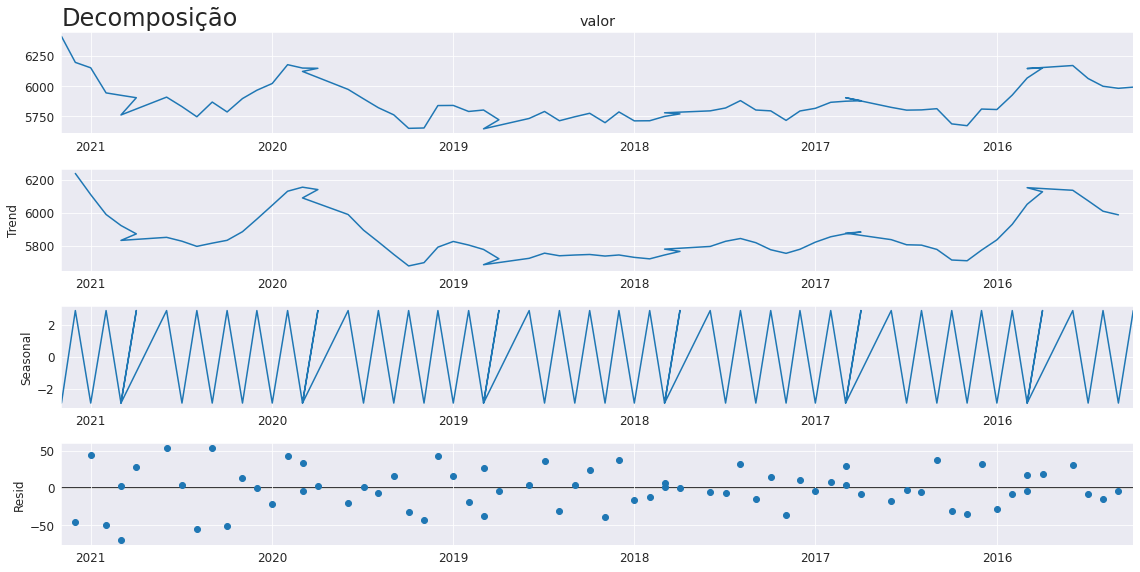

In [50]:
ax = seasonal_decompose(dados['valor'], period=2).plot()
ax.axes[0].set_title('Decomposição', loc='left', fontsize=24);

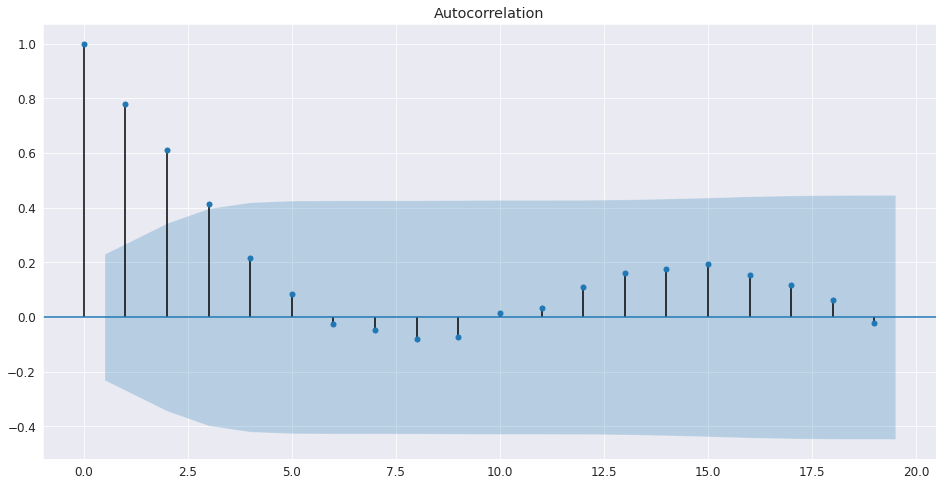

In [51]:
plot_acf(dados['valor']);

Existe uma correlação positiva no segundo lag seguida de uma queda gradual;

Modelo condicional para média: AR (autoregressivo) ou ARMA (autoregressivo por média móvel)

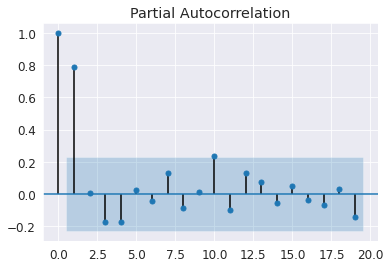

In [21]:
plot_pacf(dados['valor']);

Existe correlação parcial positiva no segundo lag seguido de uma queda brusca;

Modelo condicional para média: AR (autoregressivo)

## 3.3 Estacionariedade

In [22]:
ADF = adfuller(dados['valor'])[0]
p_value = adfuller(dados['valor'])[1]

In [23]:
print(f'''
ADF: {ADF:.2f}
P-value: {p_value:.2f}
P-value < 0.05 = {p_value < 0.05}
''')


ADF: -3.33
P-value: 0.01
P-value < 0.05 = True



A série é do tipo estacionária.

# 4 Previsão

## 4.1 Previsão com Prophet

### 4.1.1 Treino e teste

In [24]:
'''
dados_propeht: Cópia dos dados para modelagem
'''
dados_prophet = dados.copy()

In [25]:
# Resetando o indice
dados_prophet.reset_index(inplace=True)

In [26]:
# Preparação das colunas para a modelagem
dados_prophet.drop('media_movel', inplace=True, axis=1)
dados_prophet.columns = ['ds', 'y']

In [27]:
# Dados de treino e teste
dados_treino = dados_prophet[2:]
dados_teste = dados_prophet[:2]

In [28]:
# Modelo Prophet e previsão
prophet_treino = Prophet()
prophet_treino.fit(dados_treino)
futuro_treino_prophet = prophet_treino.make_future_dataframe(periods=2, freq='M')
previsao_treino_prophet = prophet_treino.predict(futuro_treino_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


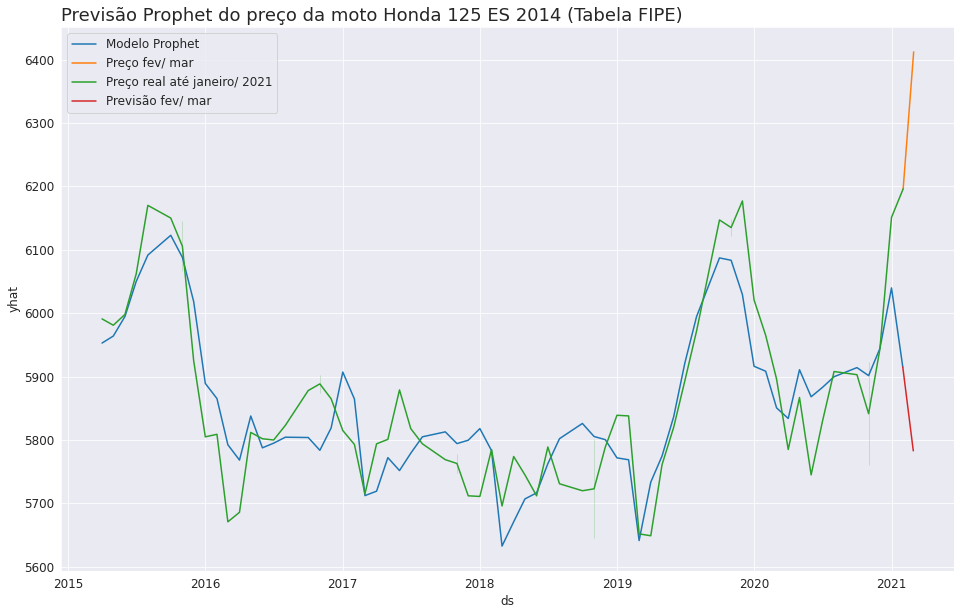

In [68]:
plt.figure(figsize=(16, 10))
sns.lineplot(x='ds', y='yhat', data=previsao_treino_prophet[:-1], label='Modelo Prophet')
sns.lineplot(x='ds', y='y', data=dados_teste, label='Preço fev/ mar')
sns.lineplot(x='data', y='valor', data=dados[1:], label='Preço real até janeiro/ 2021')
sns.lineplot(x='ds', y='yhat', data=previsao_treino_prophet[-2:], label='Previsão fev/ mar')
plt.title('Previsão Prophet do preço da moto Honda 125 ES 2014 (Tabela FIPE)',
          fontsize=18, loc='left');

In [30]:
erro_prophet = mean_squared_error(dados_teste['y'], previsao_treino_prophet['yhat'][-2:])
print(f'Erro médio quadrado: {erro_prophet:.2f}')

Erro médio quadrado: 208731.29


O modelo previu uma queda, mas houve um aumento do preço nos meses de janeiro e fevereiro de 2021, por esse motivo o erro médio quadrado foi muito alto. 

### 4.1.2 Série completa

In [31]:
# Instanciação do modelo
modelo_prophet = Prophet()

# Ajuste do modelo
modelo_prophet.fit(dados_prophet)

# DataFrame com o período futuro
future = modelo_prophet.make_future_dataframe(periods=1, freq='M')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
# Previsão
previsao_prophet = modelo_prophet.predict(future)

In [33]:
plot_components_plotly(modelo_prophet, previsao_prophet)

In [34]:
_ = plot_plotly(modelo_prophet, previsao_prophet)
_.update_layout(title_text='Modelo de previsão do preço da moto Honda 125 ES 2014 (Tabela FIPE)',
                xaxis_title='Data', yaxis_title='Casos', font=dict(size=14))

## 4.2 Previsão AUTOARIMA

In [59]:
modelo_autoarima = auto_arima(dados_treino['y'], m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=821.592, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=895.144, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=815.799, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=844.662, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1415.334, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=813.732, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=815.828, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=817.394, Time=0.51 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=814.813, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=814.936, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=843.429, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=815.301, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.481 seconds


In [61]:
modelo_autoarima.fit(dados_treino['y'])
previsao_autoarima = modelo_autoarima.predict(2)

In [65]:
previsao_autoarima

array([5971.74494179, 5955.99568073])

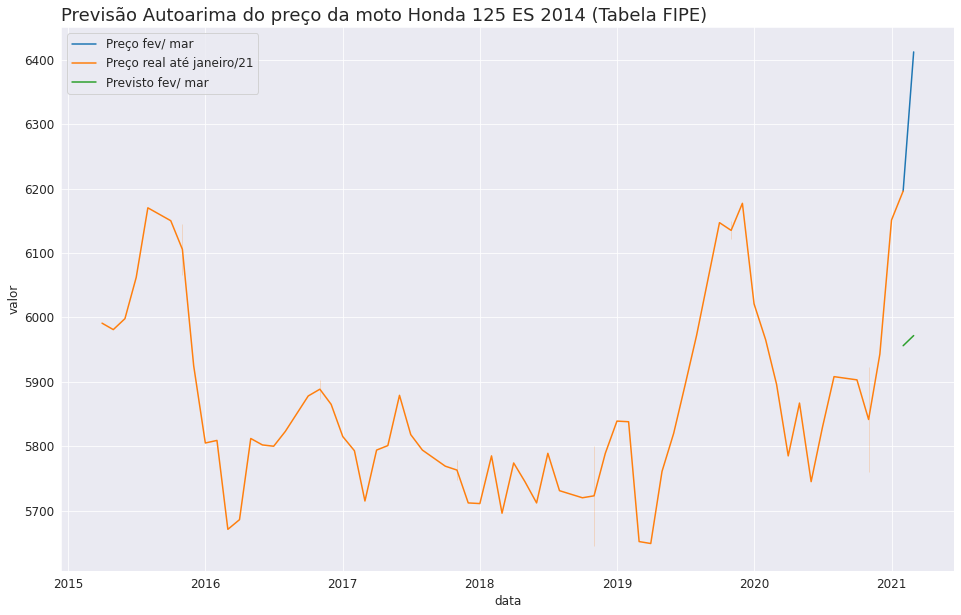

In [63]:
plt.figure(figsize=(16, 10))
sns.lineplot(x=dados.index[:2], y='valor', data=dados[:2], label='Preço fev/ mar')
sns.lineplot(x='data', y='valor', data=dados[1:], label='Preço real até janeiro/21')
sns.lineplot(x=dados.index[:2], y=previsao_autoarima, label='Previsto fev/ mar')
plt.title('Previsão Autoarima do preço da moto Honda 125 ES 2014 (Tabela FIPE)',
          fontsize=18, loc='left');

In [ ]:
erro_autoarima = mean_squared_error(dados['valor'][:2], previsao_autoarima)
print(f'Erro médio quadrado: {erro_autoarima:.2f}')

In [ ]:
print(f'''
Erro modelo Prophet: {erro_prophet}
Erro modelo Autoarima: {erro_autoarima}

Prophet - Autoarima = {erro_prophet - erro_autoarima:.2f}

O modelo Autoarima se ajustou melhor a série.''')

# 5 Considerações Finais

Qual foi o maior preço da moto na série histórica em qual data?

In [56]:
dados.sort_values('valor', ascending=False)['valor']

data
2021-03-01    6412
2021-02-01    6196
2019-12-01    6177
2015-08-01    6170
2021-01-01    6151
              ... 
2016-04-01    5686
2016-03-01    5671
2019-03-01    5652
2019-04-01    5649
2018-11-01    5645
Name: valor, Length: 72, dtype: int32

O preço atual é o melhor da série histórica.

Logo mesmo que a previsão não tenha fornecido uma informação útil pelo erro observado prevendo queda, esse é o melhor momento para vender.

# 6 Referências

MitOpenCourseWare. 11. Spectral Analysis Part 1. Disponível em: https://ocw.mit.edu/courses/brain-and-cognitive-sciences/9-40-introduction-to-neural-computation-spring-2018/lecture-videos/11.-spectral-analysis-part-1. Acesso em: 12 Fev. 2021.

Tabela FIPE. Tabela FIPE HONDA CG 125 FAN ES 2014 Gasolina. Disponível em: https://www.fipemotos.com/tabelafipe/motos/HONDA/CG-125-FAN-ES/2014-Gasolina. Acesso em: 12 Fev. 2021.



---

